In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, GRU, Convolution1D,  MaxPooling1D, Flatten,Dense,Bidirectional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc,classification_report,confusion_matrix,mean_squared_error,accuracy_score
from keras import optimizers
from itertools import cycle
import itertools
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
from keras.utils import plot_model
from datetime import datetime,timedelta
import warnings
import math
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
steps = 5
features=6
train_test_ratio = 0.7
epoch = 100
batch_size=1

In [13]:
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime

def read_and_normalization(dir,if_reverse):
    df = pd.read_csv(dir,engine='python')
    if if_reverse:
        df['trade_date']=df['trade_date'].apply(time2stamp)
        df=df.sort_values(by='trade_date')
        df.reset_index(inplace=True,drop=True)
        date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
        minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
        df_log = minmax.fit_transform(df.iloc[:, 1:].astype('float32'))
        df_log = pd.DataFrame(df_log)
    else:
        date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
        minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
        df_log = minmax.fit_transform(df.iloc[:, 1:].astype('float32'))
        df_log = pd.DataFrame(df_log)
    return date_ori,df,df_log,minmax

def reshape_and_split(data, win_size):
    # 预测下一个时刻所有特征的值
    # 预测下一个时刻某个特征的值
    # 预测下n个时刻所有特征的值
    # 预测下n个时刻某个特征的值
    input_data_x = None
    input_data_y=None
    for k in range(0,data.shape[0]-win_size):
        #index = min(k + win_size, data.shape[0]- 1)
        one_batch_x = data.iloc[k:k + win_size,:]
        one_batch_y = data.iloc[k + win_size,:]
        if input_data_x is None:
            input_data_x = one_batch_x
            input_data_y = one_batch_y
        else:
            input_data_x = np.vstack((input_data_x, one_batch_x))
            input_data_y = np.vstack((input_data_y, one_batch_y))
    print(input_data_x.shape)  #(1235, 6)       
    print(input_data_y.shape)  #(247, 6)
    reshaped_data_x=input_data_x.reshape((k+1,win_size,data.shape[1]))
    reshaped_data_y = input_data_y.reshape((k+1, 1, data.shape[1]))
    return reshaped_data_x,reshaped_data_y

def train_val_test_split(input_x,input_y,ratio):
    train_x=input_x[0:int((input_x.shape[0])*ratio)]
    test_x=input_x[int((input_x.shape[0])*ratio):]
    train_y=input_y[0:int((input_y.shape[0])*ratio)]
    test_y = input_y[int((input_y.shape[0]) * ratio):]
    train_y=np.squeeze(train_y,1)
    test_y=np.squeeze(test_y,1)
    print('train_x: ',train_x.shape)
    print('train_y: ',train_y.shape)
    print('test_x: ',test_x.shape)
    print('test_y: ',test_y.shape)
    return train_x,train_y,test_x,test_y

In [5]:
def models(win_size,fea_size):
    model = Sequential()
    # 加入正则惩罚项
    model.add(LSTM(128, input_shape=(win_size,fea_size),dropout=0.2, activation='relu',
                   return_sequences=True,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)))
    model.add(LSTM(64, dropout=0.2, activation='relu',))
    model.add(Dense(fea_size, activation='sigmoid'))
    opt = optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='mse',metrics=['accuracy'])
    model.summary()
    return model

In [6]:
def plot_train_val(history):
    fig=plt.figure(1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
def plot_pre(minmax,test_y,pred_y):
    pred_y_reverse = minmax.inverse_transform(pred_y)
    test_y_reverse = minmax.inverse_transform(test_y)
    rmse = math.sqrt(mean_squared_error(test_y_reverse, pred_y_reverse))  # multioutput='raw_values'  经计算每一列的均方误差
    print('Test RMSE: ', rmse)
    fig = plt.figure(1)
    ax = plt.subplot(111)
    open_pred=pred_y_reverse[:,0]
    open_test=test_y_reverse[:,0]
    ax.plot(open_pred,label='open pre')
    ax.plot(open_test,label='open test')
    plt.legend(loc='best')
    plt.grid(1)
    #plt.xticks(np.arange(len()))
    plt.show()

In [14]:
dir=r'C:\Users\USER\PycharmProjects\tf2\models\DL\dataset\Qingdao_SH.csv'
date_ori,df,df_log,minmax=read_and_normalization(dir,if_reverse=1)
input_x,input_y=reshape_and_split(df_log,steps)
train_x,train_y,test_x,test_y=train_val_test_split(input_x,input_y,train_test_ratio)
model=models(train_x.shape[1],train_x.shape[2])

(24975, 6)
(4995, 6)
train_x:  (3496, 5, 6)
train_y:  (3496, 6)
test_x:  (1499, 5, 6)
test_y:  (1499, 6)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 128)            69120     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 118,918
Trainable params: 118,918
Non-trainable params: 0
_________________________________________________________________


In [15]:
df_log

,0,1,2,3,4,5
0,0.004378,0.002736,0.003375,0.004027,0.005177,0.004681
1,0.004569,0.002007,0.003375,0.003452,0.004027,0.002724
2,0.003617,0.000912,0.002978,0.003068,0.003452,0.002028
3,0.001904,0.000000,0.001985,0.002493,0.003068,0.005082
4,0.002284,0.000182,0.002184,0.002301,0.002493,0.003575
...,...,...,...,...,...,...
4995,0.735389,0.718716,0.749851,0.724640,0.748035,0.298796
4996,0.726061,0.707041,0.754814,0.738447,0.724640,0.164848
4997,0.719779,0.692995,0.731189,0.718504,0.738447,0.330417
4998,0.711403,0.703393,0.741910,0.730010,0.718504,0.253296


Train on 2796 samples, validate on 700 samples
Epoch 1/100
 - 6s - loss: 6.9108e-04 - accuracy: 0.3623 - val_loss: 0.0125 - val_accuracy: 0.8014
Epoch 2/100
 - 6s - loss: 6.6351e-04 - accuracy: 0.3712 - val_loss: 0.0118 - val_accuracy: 0.8043
Epoch 3/100
 - 6s - loss: 6.5525e-04 - accuracy: 0.3662 - val_loss: 0.0122 - val_accuracy: 0.8043
Epoch 4/100
 - 6s - loss: 6.2123e-04 - accuracy: 0.3648 - val_loss: 0.0125 - val_accuracy: 0.8043
Epoch 5/100
 - 6s - loss: 6.2822e-04 - accuracy: 0.3698 - val_loss: 0.0124 - val_accuracy: 0.8043
Epoch 6/100
 - 6s - loss: 6.3123e-04 - accuracy: 0.3573 - val_loss: 0.0127 - val_accuracy: 0.8014
Epoch 7/100
 - 7s - loss: 6.1596e-04 - accuracy: 0.3648 - val_loss: 0.0127 - val_accuracy: 0.8043
Epoch 8/100
 - 7s - loss: 7.6442e-04 - accuracy: 0.3634 - val_loss: 0.0132 - val_accuracy: 0.8043
Epoch 9/100
 - 7s - loss: 6.1129e-04 - accuracy: 0.3630 - val_loss: 0.0117 - val_accuracy: 0.7757
Epoch 10/100
 - 7s - loss: 6.2345e-04 - accuracy: 0.3652 - val_loss: 0.

Epoch 84/100
 - 5s - loss: 5.5957e-04 - accuracy: 0.3644 - val_loss: 0.0119 - val_accuracy: 0.7343
Epoch 85/100
 - 5s - loss: 5.2748e-04 - accuracy: 0.3770 - val_loss: 0.0131 - val_accuracy: 0.7786
Epoch 86/100
 - 6s - loss: 5.9107e-04 - accuracy: 0.3795 - val_loss: 0.0122 - val_accuracy: 0.7300
Epoch 87/100
 - 6s - loss: 5.6579e-04 - accuracy: 0.3788 - val_loss: 0.0121 - val_accuracy: 0.7486
Epoch 88/100
 - 6s - loss: 5.3763e-04 - accuracy: 0.3716 - val_loss: 0.0119 - val_accuracy: 0.7643
Epoch 89/100
 - 6s - loss: 5.4511e-04 - accuracy: 0.3677 - val_loss: 0.0113 - val_accuracy: 0.8000
Epoch 90/100
 - 6s - loss: 5.4579e-04 - accuracy: 0.3723 - val_loss: 0.0130 - val_accuracy: 0.7929
Epoch 91/100
 - 7s - loss: 5.4192e-04 - accuracy: 0.3770 - val_loss: 0.0116 - val_accuracy: 0.8000
Epoch 92/100
 - 6s - loss: 6.4729e-04 - accuracy: 0.3741 - val_loss: 0.0124 - val_accuracy: 0.8000
Epoch 93/100
 - 6s - loss: 5.4798e-04 - accuracy: 0.3777 - val_loss: 0.0110 - val_accuracy: 0.8000
Epoch 94/1

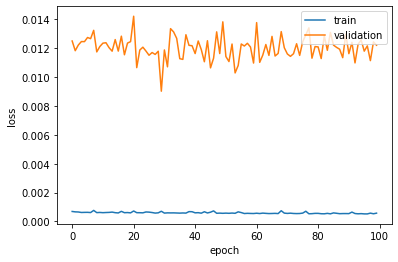

Test RMSE:  13252.187743916096


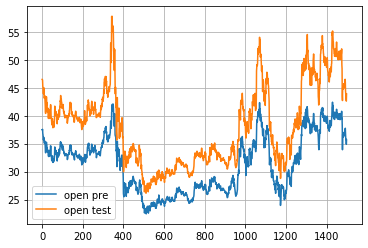

In [19]:
history = model.fit(train_x, train_y, nb_epoch=epoch, batch_size=16,verbose=2, validation_split=0.2)  # callbacks=callbacks_list
plot_train_val(history)
pred_y = model.predict(test_x, batch_size=batch_size,verbose=2)
plot_pre(minmax,test_y,pred_y)

In [20]:
def predictFuture(model,last_test_sample,win,features,future_steps):
    '''
    预测未来多步时刻
    :param model:
    :param dataset:
    :param features:
    :param step:
    :param next_num:
    :return:
    '''
    predicted_list=[]
    for i in range(future_steps):
        one_next=last_test_sample[i:i+win]
        one_next=np.array(one_next).reshape(1,win,features)
        next_predicted = model.predict(one_next)
        predicted_list.append(next_predicted)
        last_test_sample = np.vstack((last_test_sample, next_predicted))
    return last_test_sample,predicted_list

In [23]:
last_test=test_x[-1]
last_,next_predicted_list=predictFuture(model,last_test,steps,features,future_steps=5)

In [44]:
def dataCruvePloter(last_list,future_list):
    fig=plt.figure()
    ax=plt.subplot()
    factor=['open','high','low','close','pre_close','vol']
    pred_y_reverse = minmax.inverse_transform(future_list)
    test_y_reverse = minmax.inverse_transform(last_list)
    for fea_num in range(5):
        real=[test_y_reverse[i][fea_num] for i in range(len(test_y_reverse))]
        future=[pred_y_reverse[i][fea_num] for i in range(len(pred_y_reverse))]
        ax.plot(range(len(real)),real,label=factor[fea_num]+' True')
        ax.plot(range(len(real),len(real)+len(future)),future,label=factor[fea_num]+' Predict',ls=':')
    ax.legend(loc='best',ncol=2)
    # plt.savefig(save_path)

In [38]:
predict_next=next_predicted_list[0]
for i in range(1,len(next_predicted_list)):
    predict_next=np.vstack((predict_next,next_predicted_list[i]))
predict_next

array([[0.57910764, 0.56409866, 0.59316975, 0.5833319 , 0.58496094,
        0.15109485],
       [0.44250506, 0.42951116, 0.4535051 , 0.45152488, 0.44730648,
        0.07852035],
       [0.31547874, 0.311271  , 0.31786466, 0.32246375, 0.31714147,
        0.0487659 ],
       [0.18333107, 0.18174186, 0.18428594, 0.18913019, 0.18695529,
        0.02725956],
       [0.08533782, 0.08265978, 0.08554053, 0.08664581, 0.08558879,
        0.00958817]], dtype=float32)

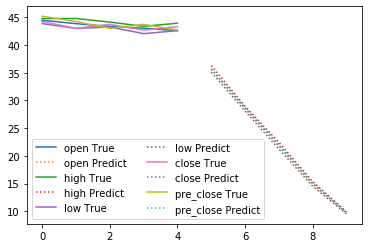

In [45]:
dataCruvePloter(last_test,predict_next)

# 画图：每步预测结果

In [82]:
def All_predict(model,dataset,win,features):
    predicted_list=[]
    predict_results=dataset[0]
    for i in range(dataset.shape[0]):
        one_next=dataset[i]
        one_next=one_next.reshape(1,win,features)
        next_predicted = model.predict(one_next)
        predict_results = np.vstack((predict_results, next_predicted))
    return predict_results


def all_Ploter(data_list,future_list):
    fig=plt.figure(figsize=(20,12))
    
    factor=['open','high','low','close','pre_close','volume']
    pred_reverse = minmax.inverse_transform(future_list)
    real_reverse = minmax.inverse_transform(data_list)
    
    ax1=plt.subplot(321)
    real=[real_reverse[i][0] for i in range(len(real_reverse))]
    future=[pred_reverse[i][0] for i in range(len(future_list))]
    ax1.plot(range(len(real)),real,label=factor[0]+' True')
    ax1.plot(range(len(real)),future,label=factor[0]+' Predict',ls=':')
    
    ax2=plt.subplot(322)
    real=[real_reverse[i][1] for i in range(len(real_reverse))]
    future=[pred_reverse[i][1] for i in range(len(future_list))]
    ax2.plot(range(len(real)),real,label=factor[1]+' True')
    ax2.plot(range(len(real)),future,label=factor[1]+' Predict',ls=':')
    
    ax3=plt.subplot(323)
    real=[real_reverse[i][2] for i in range(len(real_reverse))]
    future=[pred_reverse[i][2] for i in range(len(future_list))]
    ax3.plot(range(len(real)),real,label=factor[2]+' True')
    ax3.plot(range(len(real)),future,label=factor[2]+' Predict',ls=':')
    
    ax4=plt.subplot(324)
    real=[real_reverse[i][3] for i in range(len(real_reverse))]
    future=[pred_reverse[i][3] for i in range(len(future_list))]
    ax4.plot(range(len(real)),real,label=factor[3]+' True')
    ax4.plot(range(len(real)),future,label=factor[3]+' Predict',ls=':')
    
    ax5=plt.subplot(325)
    real=[real_reverse[i][4] for i in range(len(real_reverse))]
    future=[pred_reverse[i][4] for i in range(len(future_list))]
    ax5.plot(range(len(real)),real,label=factor[4]+' True')
    ax5.plot(range(len(real)),future,label=factor[4]+' Predict',ls=':')
    
    ax6=plt.subplot(326)
    real=[real_reverse[i][5] for i in range(len(real_reverse))]
    future=[pred_reverse[i][5] for i in range(len(future_list))]
    ax6.plot(range(len(real)),real,label=factor[5]+' True')
    ax6.plot(range(len(real)),future,label=factor[5]+' Predict',ls=':')
    
    #plt.xticks(np.arange(len(pred_reverse)+len(real_reverse))[::500],datesss[::500])
    # plt.savefig(save_path)

In [70]:
print(df_log.values.shape)
print(predict_results.shape)

(24975, 6)
(5000, 6)


In [ ]:
predict_results=All_predict(model,input_x,steps,features,)

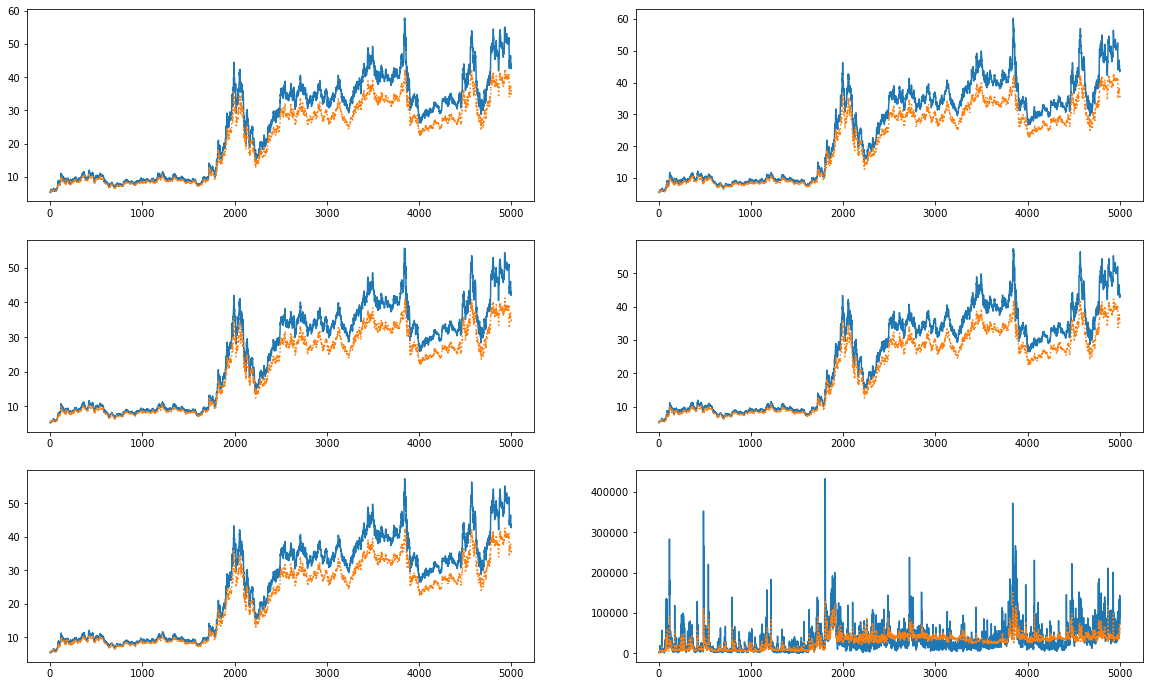

In [83]:
#input_x_2D=input_x.reshape(-1,features)
all_Ploter(df_log.values,predict_results)

In [81]:
predict_results=All_predict(model,input_x,steps,features,)
predict_results

array([[0.12328506, 0.09392309, 0.12408018, 0.11270809, 0.11270809,
        0.2805493 ],
       [0.08311939, 0.05417991, 0.1088078 , 0.09000754, 0.09000754,
        0.2960068 ],
       [0.0222652 , 0.05557251, 0.07954454, 0.0896275 , 0.0896275 ,
        0.3378381 ],
       ...,
       [0.50044835, 0.5001091 , 0.48913085, 0.4914795 , 0.4886678 ,
        0.4997605 ],
       [0.500835  , 0.5001375 , 0.48876458, 0.49104658, 0.48756996,
        0.4996605 ],
       [0.5009297 , 0.50010735, 0.48826793, 0.49063453, 0.48674127,
        0.4995987 ]], dtype=float32)

In [58]:
dir=r'C:\Users\USER\PycharmProjects\tf2\models\DL\dataset\Qingdao_SH.csv'
dddd = pd.read_csv(dir,engine='python')
    
dddd['trade_date']=dddd['trade_date'].apply(time2stamp)
dddd=dddd.sort_values(by='trade_date')
dddd.reset_index(inplace=True,drop=True)
datesss=dddd['trade_date'].values

In [62]:
datesss[::1000]

array(['1999-02-01T00:00:00.000000000', '2003-05-13T00:00:00.000000000',
       '2007-10-16T00:00:00.000000000', '2011-12-06T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000'], dtype='datetime64[ns]')